In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *

### Simulation Settings + Define Operators

In [2]:
# Highest Fock state
nMax = 100

# Size of Wigner function to plot (set to match the plots from the paper)
xvec = np.linspace(-3, 3, 200)
pvec = np.linspace(-2, 12, 200)

# QuTip integration settings
options = Options()
options.num_cpus = 5
options.nsteps = 100000

# Define Operators
a = tensor(qeye(2), destroy(nMax))
x = tensor(qeye(2), position(nMax))

sX = tensor(sigmax(), qeye(nMax))
sY = tensor(sigmay(), qeye(nMax))
sZ = tensor(sigmaz(), qeye(nMax))
sM = tensor(destroy(2), qeye(nMax))

In [3]:
def t_k(k, omega):
    prefactor = 2 * np.sqrt(2)
    
    num = k * (1 + k) * (2 + k)
    denom = 1 + 3 * k * (2 + k)
    
    return prefactor * np.sqrt(num/denom) * np.pi / omega

def d_k(k, omega):
    return 2 * np.pi * (k + 1) / t_k(k, omega)

print(str(np.round(t_k(17, omega = 2 * np.pi * 1.18*10**(3))*10**(6), 3)) + ' us')
print(str(np.round(d_k(17,  1.18*10**(3))*10**(-3), 3)) + ' khz')

2934.166 us
6.135 khz


In [40]:
# -------------------- Setup Operators -------------------- #
rsb = a * sM.dag()
def rsb_coeff(t, args):
    return args['omega'] * np.sin(np.pi * t / args['gate_time']) * np.exp(1j * args['rsb_phase']) * np.exp(-1j * args['rsb_detuning'] * t)

rsbp = a.dag() * sM 
def rsbp_coeff(t, args):
    return args['omega'] * np.sin(np.pi * t / args['gate_time']) * np.exp(-1j * args['rsb_phase']) * np.exp(1j * args['rsb_detuning'] * t)

bsb = a.dag() * sM.dag()
def bsb_coeff(t, args):
    return args['omega'] * np.sin(np.pi * t / args['gate_time']) * np.exp(1j * args['bsb_phase']) * np.exp(-1j * args['bsb_detuning'] * t)

bsbp = a * sM
def bsbp_coeff(t, args):
    return args['omega'] * np.sin(np.pi * t / args['gate_time']) * np.exp(-1j * args['bsb_phase']) * np.exp(1j * args['bsb_detuning'] * t)

push = [ [rsb, rsb_coeff], [rsbp, rsbp_coeff], [bsb, bsb_coeff], [bsbp, bsbp_coeff] ]
    
order = 10
omega = np.pi / (100 * 10**(-6)) # Given by pi-time of RSB/BSB transitions

gate_time = t_k(order, omega)
optimal_detuning = d_k(order, omega)

print("For k = " + str(order))
print("Optimal Time = " + str(np.round(gate_time/2 * 10**(6), 3)) + ' us')
print("Optimal Detuning = " + str(np.round(optimal_detuning / (2 * np.pi), 3)) + 'Hz')

For k = 10
Optimal Time = 270.426 us
Optimal Detuning = 20338.285Hz


Text(0, 0.5, 'Momentum')

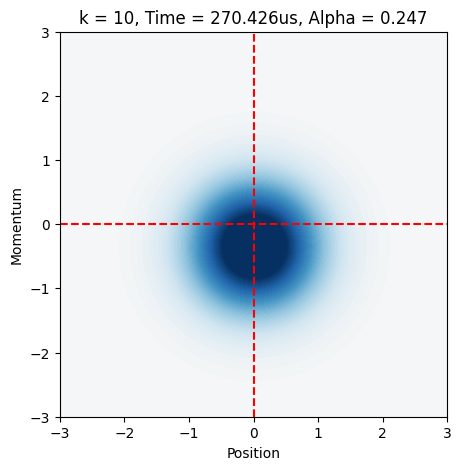

In [41]:
tlist = np.linspace(0, gate_time/2, 100)

args = {"omega": omega, "gate_time": gate_time, "rsb_detuning": optimal_detuning, "bsb_detuning": -optimal_detuning, "rsb_phase": np.pi/2, "bsb_phase": -np.pi/2}

# -------------------- Verify Above Hamiltonian is Correct -------------------- #
# Change plot range on Wigner so that it's easier to see
xxvec = np.linspace(-3, 3, 200)
ppvec = np.linspace(-3, 3, 200)

# |+> initial state
initial_state = tensor(basis(2,0) + basis(2,1), basis(nMax, 0)) # |+> state -> If displacement has correct PauliX control, no splitting should be observed

output = mesolve(H = push, rho0 = initial_state, tlist = tlist, args = args).states[-1]
motion = ptrace(output, 1)
nBar = np.sum([i * np.real(np.diag(motion)[i]) for i in range(nMax)])

w = wigner(motion, xxvec, ppvec)

# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

ax.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
ax.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')

im = ax.contourf(xxvec, ppvec, w, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("k = " + str(order) + ", Time = " + str(np.round(gate_time * 10**(6)/2, 3)) + "us, Alpha = " + str(np.round(np.sqrt(nBar), 3)))
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

In [43]:
from gen_cubic_phase_sequence import generate_cubic_sequence as generator

pulse_time = 0.147

pulse_number = 10
displacement = 7

pulse_seq = generator(pulse_time, pulse_number, displacement)

Optimization terminated successfully.
For Displacement =  7
Solution for Optimal Angles:  [-2.19739392  0.03042781 -0.11828143 -0.24953153 -0.35330631 -0.3944445
 -0.35337261 -0.24939193  3.02331905  0.03011655  0.94443905]
Calculated infidelity:  0.184 



In [ ]:
# -------------------- Pulse Function -------------------- #
def pulse_ion(initial_state, angle, pulse_time, init = False):
    H1 = angle * sX
    H2 = push
    
    if init == True: # Initial (phi_0) carrier rotation
        output = mesolve(H = H1, rho0 = initial_state, tlist = tlist, args = args, options = options)
        rho1 = output.states[-1]
        
        return rho1

    else: # All other terms -> The terms in brackets in equation above
        output = mesolve(H = H1, rho0 = initial_state, tlist = tlist, args = args, options = options)
        rho1 = output.states[-1]
        
        output2 = mesolve(H = H2, rho0 = rho1, tlist = [0.0, pulse_time], args = args, options = options)
        rho2 = output2.states[-1]
        
        return rho2
    
# Begin in + state since conditional-PauliX displacement
initial_state = tensor((basis(2,0) + 1j * basis(2,1)), basis(nMax, 0)) 

for i in pulse_seq: # Iterative Evolution over rho
    if i == pulse_seq[0]: # Initial pulse
        rho  = pulse_ion(initial_state = initial_state,angle = i, pulse_time = pulse_time, detuning = 0, init = True)
        
    else:
        rho = pulse_ion(initial_state = rho, angle = i, pulse_time = pulse_time, detuning = 0, init = False)
    
rho_ion = rho
motion_ion = ptrace(rho_ion, 1)

wigner_ion = wigner(motion_ion, xvec, pvec)  

# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Lines to show center of Wigner Function (just for convenience)
ax.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
ax.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
    
im = ax.contourf(xvec, pvec, wigner_ion, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Ion " + str(pulse_number) + " Pulse Solution, X3 = 1")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1)